In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
# Manual Data Construction
student_basket = [
    {'Item': 'Tuition', 'Price_2016': 45000, 'Price_2024': 58000},
    {'Item': 'Rent (1 Bed)', 'Price_2016': 1200, 'Price_2024': 1800},
    {'Item': 'Chipotle Burrito', 'Price_2016': 7.50, 'Price_2024': 11.50},
    {'Item': 'Panera Bread', 'Price_2016': 8.99, 'Price_2024': 13.49}
]



In [6]:
# Define the "Machine" (Function)
def calculate_inflation(base, current):
    return ((current - base) / base) * 100

# Run the Loop
for item in student_basket:
    rate = calculate_inflation(item['Price_2016'], item['Price_2024'])
    print(f"{item['Item']}: {rate:.2f}% Inflation")

Tuition: 28.89% Inflation
Rent (1 Bed): 50.00% Inflation
Chipotle Burrito: 53.33% Inflation
Panera Bread: 50.06% Inflation


In [7]:
!pip install fredapi

from fredapi import Fred


fred = Fred(api_key='199cf7203ff4bae6af3636aecc77740b')

# Step 2.1: Data Proxy Strategy — Fetch Required CPI Series

official_cpi = fred.get_series('CPIAUCSL')        # Official CPI (benchmark)
tuition = fred.get_series('CUSR0000SEEB')          # Tuition, Fees & Childcare
rent = fred.get_series('CUSR0000SEHA')             # Rent of Primary Residence
streaming = fred.get_series('CUSR0000SERA02')      # Cable & Streaming TV
food_away = fred.get_series('CUSR0000SEFV')        # Food Away From Home

# Combine into a single DataFrame
cpi_df = pd.DataFrame({
    'Official CPI': official_cpi,
    'Tuition CPI': tuition,
    'Rent CPI': rent,
    'Streaming CPI': streaming,
    'Food Away CPI': food_away
})

# Restrict to relevant years (optional but recommended)
cpi_df = cpi_df.loc['2016-01-01':]

# Preview
cpi_df.tail()



,Official CPI,Tuition CPI,Rent CPI,Streaming CPI,Food Away CPI
2025-08-01,323.364,895.305,437.462,592.604,384.909
2025-09-01,324.368,897.302,438.322,593.928,385.451
2025-10-01,NaN,NaN,NaN,NaN,NaN
2025-11-01,325.031,902.001,438.875,599.226,387.202
2025-12-01,326.030,903.402,440.034,605.825,389.889


In [9]:
# Step 2.2: Normalize all CPI series to start at 100 in 2016

base_year = '2016-01-01'

# Create a normalized index DataFrame
indexed_df = cpi_df.copy()

for column in indexed_df.columns:
    indexed_df[column] = (indexed_df[column] / indexed_df.loc[base_year, column]) * 100

# Preview normalized values
indexed_df.head()


,Official CPI,Tuition CPI,Rent CPI,Streaming CPI,Food Away CPI
2016-01-01,100.000000,100.000000,100.000000,100.000000,100.000000
2016-02-01,99.867032,100.241572,100.314364,100.723912,100.138869
2016-03-01,100.180095,100.470288,100.607131,101.450163,100.355827
2016-04-01,100.563850,100.692146,100.924580,101.878663,100.599712
2016-05-01,100.801592,100.929861,101.258485,102.214306,100.813978


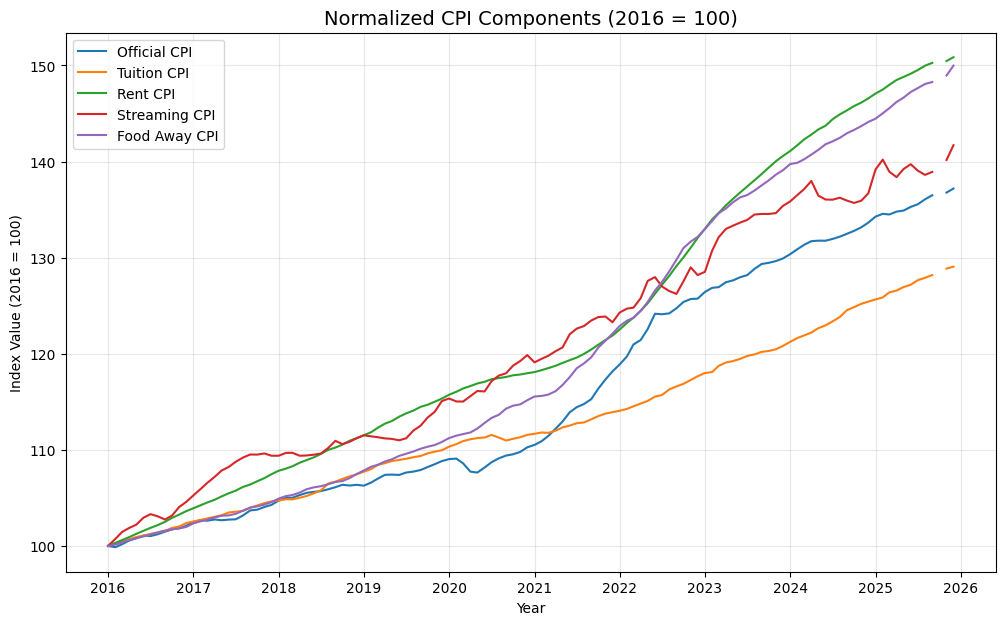

In [10]:
# Step 3.1: Plot all normalized CPI series on one chart

plt.figure(figsize=(12, 7))

for column in indexed_df.columns:
    plt.plot(indexed_df.index, indexed_df[column], label=column)

plt.title('Normalized CPI Components (2016 = 100)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Index Value (2016 = 100)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()


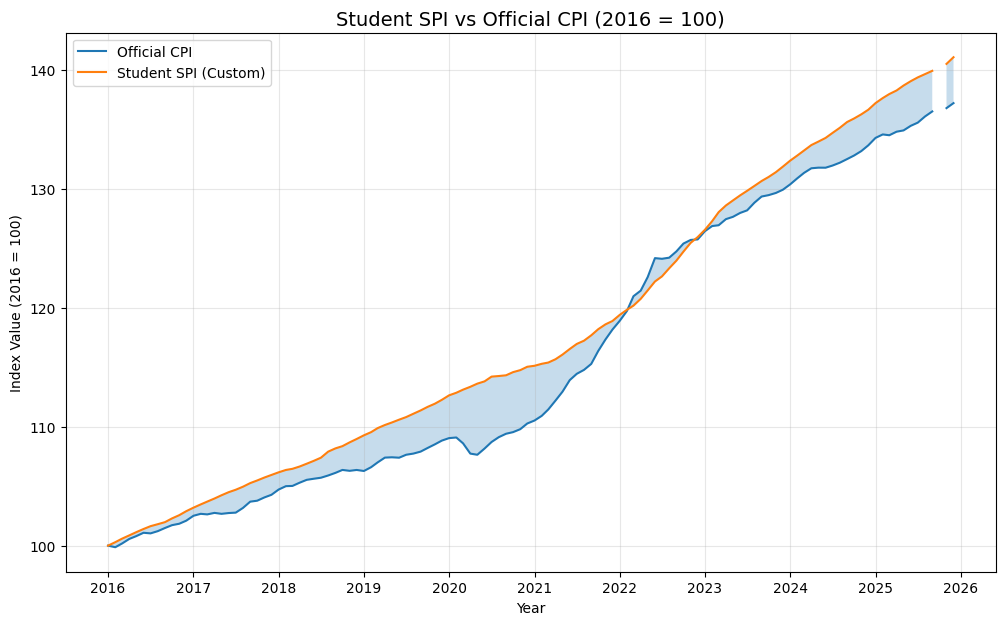

In [11]:
# Step 3.2: Weighted "Student SPI" (2016 = 100)

# 1) Define weights (must sum to 1.0)
weights = {
    'Tuition CPI': 0.40,
    'Rent CPI': 0.30,
    'Food Away CPI': 0.20,     # Chipotle proxy
    'Streaming CPI': 0.10      # Spotify/Netflix proxy
}

# 2) Calculate Student_SPI as weighted sum of normalized indices
indexed_df['Student_SPI'] = sum(indexed_df[col] * w for col, w in weights.items())

# 3) Plot Student_SPI vs Official CPI + highlight inflation gap
plt.figure(figsize=(12, 7))

plt.plot(indexed_df.index, indexed_df['Official CPI'], label='Official CPI')
plt.plot(indexed_df.index, indexed_df['Student_SPI'], label='Student SPI (Custom)')

plt.fill_between(
    indexed_df.index,
    indexed_df['Official CPI'],
    indexed_df['Student_SPI'],
    alpha=0.25
)

plt.title('Student SPI vs Official CPI (2016 = 100)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Index Value (2016 = 100)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()


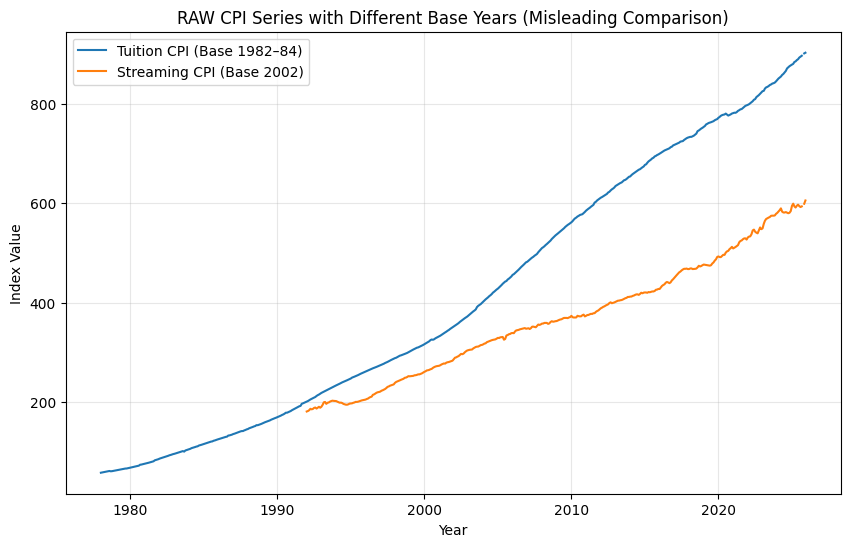

In [12]:
# RAW (non-normalized) CPI data
plt.figure(figsize=(10, 6))

plt.plot(tuition.index, tuition, label='Tuition CPI (Base 1982–84)')
plt.plot(streaming.index, streaming, label='Streaming CPI (Base 2002)')

plt.title('RAW CPI Series with Different Base Years (Misleading Comparison)')
plt.xlabel('Year')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()


Why This Chart Is a “Data Crime”

Comparing raw CPI index values with different base years is misleading because CPI values are relative, not absolute. Each series is indexed to its own reference year (e.g., Tuition uses a 1982–84 base while Streaming uses a 2002 base). The magnitude of the index reflects cumulative inflation since its base year, not the actual level or importance of the good.

As a result, plotting these raw series together falsely suggests that tuition costs are inherently “larger” or more significant than streaming costs, when in reality the difference is driven entirely by different index origins. This violates basic principles of comparability and scale integrity.

Normalization (re-indexing all series to a common start date such as 2016 = 100) is required to make meaningful comparisons of growth rates over time. Without normalization, conclusions drawn from relative line heights are statistically invalid and analytically misleading.


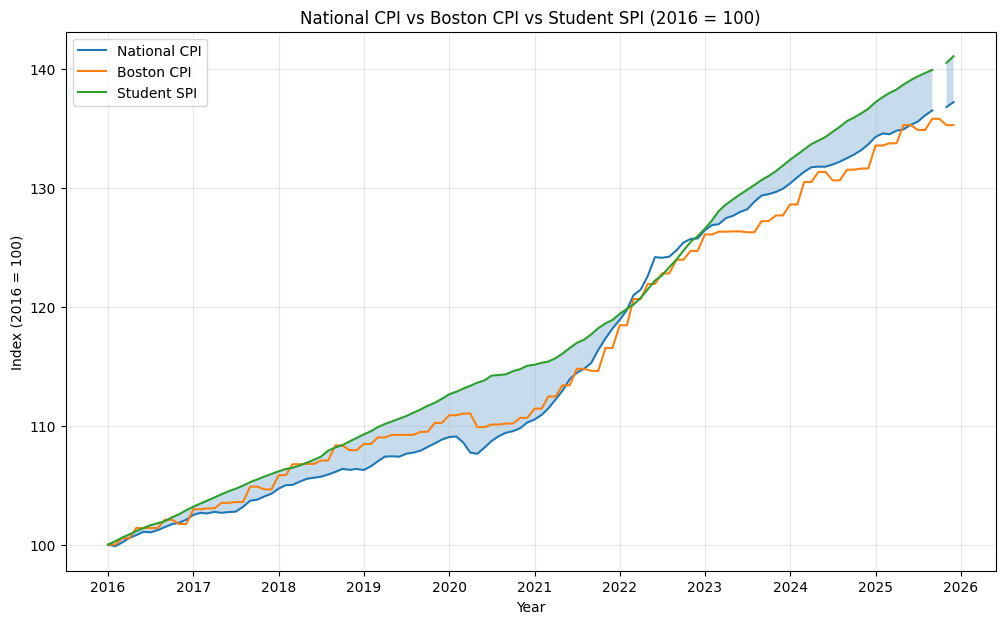

In [14]:
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt

fred = Fred(api_key='199cf7203ff4bae6af3636aecc77740b')

# 1) Fetch Boston CPI (RAW)
boston_raw = fred.get_series('CUURA103SA0')
boston_raw.index = pd.to_datetime(boston_raw.index)

# 2) Align Boston CPI to indexed_df timeline (handles missing months)
boston_aligned = boston_raw.reindex(indexed_df.index).ffill()

# 3) Normalize Boston CPI to 2016 = 100
base_date = pd.Timestamp('2016-01-01')
base_value = boston_aligned.loc[base_date]

# Safety fallback (in case Jan 2016 is missing)
if pd.isna(base_value):
    base_value = boston_aligned.loc[base_date:].dropna().iloc[0]

indexed_df['Boston CPI'] = (boston_aligned / base_value) * 100

# 4) Plot National CPI vs Boston CPI vs Student SPI
plt.figure(figsize=(12, 7))

plt.plot(indexed_df.index, indexed_df['Official CPI'], label='National CPI')
plt.plot(indexed_df.index, indexed_df['Boston CPI'], label='Boston CPI')
plt.plot(indexed_df.index, indexed_df['Student_SPI'], label='Student SPI')

# Highlight inflation gap (Student vs National)
plt.fill_between(
    indexed_df.index,
    indexed_df['Official CPI'],
    indexed_df['Student_SPI'],
    where=(indexed_df['Student_SPI'] > indexed_df['Official CPI']),
    interpolate=True,
    alpha=0.25
)

plt.title('National CPI vs Boston CPI vs Student SPI (2016 = 100)')
plt.xlabel('Year')
plt.ylabel('Index (2016 = 100)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()
